In [141]:
from sklearn.metrics import f1_score
import copy
from sklearn.metrics import roc_auc_score
from tqdm import tqdm


import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.optim import lr_scheduler
from torchsummary import summary
import os

from kornia.losses import *

# Implementacao manual
import torch.nn.functional as F
from torch.autograd import Variable

# Treinar o modelo
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

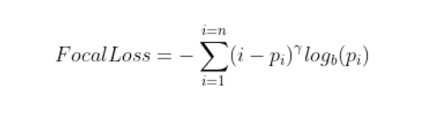

## Funcao Extra

In [142]:

class FocalLoss2(nn.Module):
    def __init__(self, gamma=0, alpha=None, size_average=True):
        super(FocalLoss2, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        if isinstance(alpha,(float,int)): self.alpha = torch.Tensor([alpha,1-alpha])
        if isinstance(alpha,list): self.alpha = torch.Tensor(alpha)
        self.size_average = size_average

    def forward(self, input, target):
        if input.dim()>2:
            input = input.view(input.size(0),input.size(1),-1)  # N,C,H,W => N,C,H*W
            input = input.transpose(1,2)    # N,C,H*W => N,H*W,C
            input = input.contiguous().view(-1,input.size(2))   # N,H*W,C => N*H*W,C
        target = target.view(-1,1)

        logpt = F.log_softmax(input, dim=1)
        logpt = logpt.gather(1,target)
        logpt = logpt.view(-1)
        pt = Variable(logpt.data.exp())

        if self.alpha is not None:
            if self.alpha.type()!=input.data.type():
                self.alpha = self.alpha.type_as(input.data)
            at = self.alpha.gather(0,target.data.view(-1))
            logpt = logpt * Variable(at)

        loss = -1 * (1-pt)**self.gamma * logpt
        if self.size_average: return loss.mean()
        else: return loss.sum()

## Preparacao dos Dados

In [143]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

df = pd.read_csv('tabelacompleta.csv')
df.drop(['url_img_satelite', 'img'], axis=1, inplace=True)

# Transformando aeroporto em variaveis numericas
enc = LabelEncoder()
enc.fit(df['origem'].unique().tolist())
df['origem'] = enc.transform(df['origem'])
df['destino'] = enc.transform(df['destino'])

# Scaler das variaveis
scl = StandardScaler()
df_aux = pd.DataFrame(scl.fit_transform(df.drop(['flightid', 'espera'], axis=1)), columns=df.drop(['flightid', 'espera'], axis=1).columns)
df_aux['flightid'] = df['flightid']
df_aux['espera'] = df['espera']

# Separacao treino e teste kaggle
df_train = df[df['espera'].notna()]
df_test = df[df['espera'].isna()]

# Removendo casos que nao foi possivel extrair imagens
import glob
imgs_validas = pd.Series(glob.glob('dados/imgs/ImagensHibrido/*')).apply(lambda txt: str(txt).split('\\')[-1].split('.')[0])
df_train = df_train.loc[df_train['flightid'].isin(imgs_validas)]


# Oversampling dos dados minoritarios
oversampling = df_train.loc[df_train['espera']==1]
n_oversamipling = 20

for i in range(n_oversamipling):
    df_train = pd.concat([df_train, oversampling], axis=0)

train, val = train_test_split(df_train, test_size=0.2, random_state=42)

In [144]:
# Fine Tuning final com proporcao 50:50
df_fine_train = df[df['espera'].notna()]
df_fine_train = df_fine_train.loc[df_fine_train['flightid'].isin(imgs_validas)]

df_fine_train.loc[df_fine_train['espera'] == 0]

espera = df_fine_train.loc[df_fine_train['espera']==1]
n_oversamipling = 20

sem_espera = df_fine_train.loc[df_fine_train['espera'] == 0]
sem_espera, _ = train_test_split(sem_espera, train_size=espera.shape[0]*n_oversamipling/sem_espera.shape[0], random_state=42)

for i in range(n_oversamipling):
    sem_espera = pd.concat([sem_espera, oversampling], axis=0)

fine_train, fine_val = train_test_split(sem_espera, test_size=0.2, random_state=42)

## Modelo

In [145]:
import torch
import torch.nn as nn
import torchvision.models as models

class HybridModel(nn.Module):
    def __init__(self, num_classes, num_numeric_features):
        super(HybridModel, self).__init__()

        # ResNet para processamento de imagens
        self.resnet = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
        for param in self.resnet.parameters():
            param.requires_grad = False

        # Cauda densa da resnet
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Sequential(
            nn.Linear(num_ftrs, 512),  
            nn.ReLU(),
            nn.Linear(512, 128),  
            nn.ReLU()
        )
        
        # Camadas para processamento de variáveis numéricas
        self.numeric_layers = nn.Sequential(
            nn.Linear(num_numeric_features, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU()
            
        )
        
        # Camada final para combinar as saídas da ResNet e das camadas numéricas
        self.final_layers = nn.Sequential(
            nn.Linear(256, 128),
            nn.Sigmoid(),
            nn.Linear(128, 64),
            nn.Sigmoid(),
            nn.Linear(64, 32),
            nn.Sigmoid(),
            nn.Linear(32, num_classes),
            nn.Softmax(dim=1)
        )

    def forward(self, image, numeric):
        image_features = self.resnet(image)
        numeric_features = self.numeric_layers(numeric)
        
        # Combinando as características das imagens e numéricas
        combined_features = torch.cat((image_features, numeric_features), dim=1)
        
        # Passando as características combinadas pelas camadas finais
        output = self.final_layers(combined_features)
        return output

# Variaveis de entrada
num_classes = df_train['espera'].nunique()  # Número de classes de saída
num_numeric_features = df_train.drop(['espera', 'flightid'], axis=1).shape[1]  # Número de características numéricas

# Criando uma instância do modelo
model = HybridModel(num_classes, num_numeric_features)
print(num_classes, num_numeric_features)


2 23


### Dataset Iteravel

In [146]:
import pandas as pd
import torch
import PIL
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

data_transforms = transforms.Compose([
    transforms.Resize(224),  # Redimensionar todas as imagens para 224x224
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


class CustomDataset(Dataset):
    def __init__(self, dataframe, PATH, predict = False, image_transform=None):
        self.dataframe = dataframe
        self.image_transform = image_transform
        self.PATH = PATH
        self.predict = predict

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        
        # Consumir imagem
        image = PIL.Image.open(self.PATH + row['flightid'] + '.jpg')
        if self.image_transform:
            image = self.image_transform(image)
        
        # Dados numericos
        numeric_features = row.drop(['espera', 'flightid']).values.astype(float)
        
        # Label 
        label = row['espera']

        # Saida para treino ou predicao
        if self.predict:
            return image, numeric_features, label, row['flightid']
        return image, numeric_features, label

# Instância do conjunto de dados personalizado
train_dataset = CustomDataset(dataframe=train, image_transform=data_transforms, PATH='dados/imgs/ImagensHibrido/')
val_dataset = CustomDataset(dataframe=val, image_transform=data_transforms, PATH='dados/imgs/ImagensHibrido/')


batch_size = 64
dataloaders = {
    'train': DataLoader(train_dataset, batch_size=batch_size, shuffle=True),
    'val': DataLoader(val_dataset, batch_size=batch_size, shuffle=True),
}

dataset_sizes = {
    'train': len(train_dataset),
    'val': len(val_dataset)
}

# Definicao do conjunto de fine tuning
fine_train_dataset = CustomDataset(dataframe=fine_train, image_transform=data_transforms, PATH='dados/imgs/ImagensHibrido/')
fine_val_dataset = CustomDataset(dataframe=fine_val, image_transform=data_transforms, PATH='dados/imgs/ImagensHibrido/')

fine_batch_size = 24
fine_dataloaders = {
    'train': DataLoader(fine_train_dataset, batch_size=batch_size, shuffle=True),
    'val': DataLoader(fine_val_dataset, batch_size=batch_size, shuffle=True),
}

fine_dataset_sizes = {
    'train': len(fine_train_dataset),
    'val': len(fine_val_dataset)
}


## Treinamento

In [148]:
model = model.to(device)

# weights = [0.4, 0.6]
# class_weights = torch.tensor(weights, dtype=torch.float).to(device)
# criterion = nn.CrossEntropyLoss(weight=class_weights)
criterion = nn.CrossEntropyLoss()

# criterion = FocalLoss2()
# criterion = FocalLoss2(alpha = 0.7, gamma=1)

parametros = list(model.resnet.fc.parameters()) + list(model.numeric_layers.parameters()) + list(model.final_layers.parameters())

# optimizer = optim.Adam(parametros, lr=0.0005, weight_decay=0.001)
optimizer = optim.SGD(parametros, lr=0.0005, weight_decay=0.001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

def calculate_f1(preds, labels):
    preds = preds.cpu().numpy()
    labels = labels.cpu().numpy()
    return f1_score(labels, preds, average='weighted')

def safe_auc_score(y_true, y_score):
    try:
        auc = roc_auc_score(y_true, y_score)
    except ValueError:
        auc = 0.5  # AUC é 0.5 quando todos os rótulos pertencem a uma única classe
    return auc


def train_model(model, criterion, optimizer, dataloaders, dataset_sizes, scheduler=None, num_epochs=25, patience = 15):
    best_loss = float('inf')
    epochs_no_improve = 0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Fase de treinamento
        model.train()
        running_loss = 0.0
        running_corrects = 0
        running_f1 = 0.0
        running_auc = 0.0
        progress_bar = tqdm(dataloaders['train'], desc='Training')
        iteration = 1
        for img_inputs, num_inputs, labels in progress_bar:
            img_inputs = img_inputs.to(device, dtype=torch.float32)
            num_inputs = num_inputs.to(device, dtype=torch.float32)

            outputs = model(img_inputs, num_inputs)
            _, preds = torch.max(outputs, 1)

            labels = labels.to(device, dtype=torch.int64) 
            
            loss = criterion(outputs, labels)
            
            optimizer.zero_grad()
            loss.retain_grad()
            loss.backward()
            optimizer.step()

            f1 = calculate_f1(preds, labels)
            probs = torch.softmax(outputs, dim=1)
            auc = safe_auc_score(labels.cpu().numpy(), probs.detach().cpu().numpy()[:, 1])


            running_loss += loss.item() * num_inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            running_f1 += f1 * num_inputs.size(0)
            running_auc += auc * num_inputs.size(0)

            # Atualizar a barra de progresso
            mean_it = iteration*batch_size
            progress_bar.set_postfix({'loss': running_loss/mean_it, 
                                      'accuracy': float(running_corrects.double()/mean_it),
                                      'f1': running_f1/mean_it,
                                      'auc': running_auc/mean_it,
                                      'size': mean_it})
            iteration += 1
        scheduler.step()
        epoch_loss = running_loss / dataset_sizes['train']
        epoch_acc = running_corrects.double() / dataset_sizes['train']
        epoch_f1 = running_f1 / dataset_sizes['train']
        epoch_auc = running_auc / dataset_sizes['train']

        print('Train Loss: {:.4f} Acc: {:.4f} F1: {:.4f} AUC: {:.4f} Size: {:.4f}'.format(epoch_loss, epoch_acc, epoch_f1, epoch_auc, dataset_sizes['train']))

        # Fase de validação
        model.eval()
        running_loss = 0.0
        running_corrects = 0
        running_f1 = 0.0
        running_auc = 0.0
        progress_bar = tqdm(dataloaders['val'], desc='Validation')
        iteration = 1
        for img_inputs, num_inputs, labels in progress_bar:
            img_inputs = img_inputs.to(device, dtype=torch.float32)
            num_inputs = num_inputs.to(device, dtype=torch.float32)  

            with torch.no_grad():
                outputs = model(img_inputs, num_inputs)
                _, preds = torch.max(outputs, 1)

                labels = labels.to(device, dtype=torch.int64) 
                loss = criterion(outputs, labels)

                f1 = calculate_f1(preds, labels)
                probs = torch.softmax(outputs, dim=1)
                auc = safe_auc_score(labels.cpu().numpy(), probs.detach().cpu().numpy()[:, 1])

            running_loss += loss.item() * num_inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            running_f1 += f1 * num_inputs.size(0)
            running_auc += auc * num_inputs.size(0)

            # Atualizar a barra de progresso
            mean_it = iteration*batch_size
            progress_bar.set_postfix({'loss': running_loss/mean_it, 
                                      'accuracy': float(running_corrects.double()/mean_it),
                                      'f1': running_f1/mean_it,
                                      'auc': running_auc/mean_it,
                                      'size': mean_it})
            iteration += 1
        
        epoch_loss = running_loss / dataset_sizes['val']
        epoch_acc = running_corrects.double() / dataset_sizes['val']
        epoch_f1 = running_f1 / dataset_sizes['val']
        epoch_auc = running_auc / dataset_sizes['val']


        if epoch_loss < best_loss:
            best_loss = epoch_loss
            epochs_no_improve = 0
            # Salvar os pesos do modelo
            torch.save(model.state_dict(), 'best_model.pt')
        else:
            epochs_no_improve += 1

        # Verificar se o treinamento deve ser interrompido
        if epochs_no_improve >= patience:
            print("Early stopping! No improvement in validation loss for {} epochs.".format(patience))
            break


        print('Val Loss: {:.4f} Acc: {:.4f} F1: {:.4f} AUC: {:.4f} Size: {:.4f}'.format(epoch_loss, epoch_acc, epoch_f1, epoch_auc, dataset_sizes['val']))

train_model(model, criterion, optimizer, fine_dataloaders, fine_dataset_sizes, scheduler, num_epochs=200, patience=5)

Epoch 0/199
----------


Training: 100%|██████████| 1839/1839 [03:31<00:00,  8.69it/s, loss=0.418, accuracy=0.903, f1=0.903, auc=0.914, size=117696]


Train Loss: 0.4180 Acc: 0.9029 F1: 0.9028 AUC: 0.9144 Size: 117664.0000


Validation: 100%|██████████| 460/460 [00:49<00:00,  9.24it/s, loss=0.405, accuracy=0.911, f1=0.911, auc=0.916, size=29440]


Val Loss: 0.4051 Acc: 0.9119 F1: 0.9118 AUC: 0.9163 Size: 29416.0000
Epoch 1/199
----------


Training: 100%|██████████| 1839/1839 [03:29<00:00,  8.77it/s, loss=0.418, accuracy=0.903, f1=0.902, auc=0.914, size=117696]


Train Loss: 0.4181 Acc: 0.9028 F1: 0.9027 AUC: 0.9146 Size: 117664.0000


Validation: 100%|██████████| 460/460 [00:49<00:00,  9.26it/s, loss=0.406, accuracy=0.911, f1=0.911, auc=0.917, size=29440]


Val Loss: 0.4064 Acc: 0.9119 F1: 0.9119 AUC: 0.9176 Size: 29416.0000
Epoch 2/199
----------


Training: 100%|██████████| 1839/1839 [03:28<00:00,  8.83it/s, loss=0.418, accuracy=0.903, f1=0.903, auc=0.915, size=117696]


Train Loss: 0.4176 Acc: 0.9032 F1: 0.9031 AUC: 0.9148 Size: 117664.0000


Validation: 100%|██████████| 460/460 [00:49<00:00,  9.25it/s, loss=0.404, accuracy=0.913, f1=0.913, auc=0.915, size=29440]


Val Loss: 0.4047 Acc: 0.9142 F1: 0.9141 AUC: 0.9155 Size: 29416.0000
Epoch 3/199
----------


Training: 100%|██████████| 1839/1839 [03:28<00:00,  8.83it/s, loss=0.417, accuracy=0.903, f1=0.903, auc=0.915, size=117696]


Train Loss: 0.4174 Acc: 0.9035 F1: 0.9034 AUC: 0.9149 Size: 117664.0000


Validation: 100%|██████████| 460/460 [00:49<00:00,  9.30it/s, loss=0.402, accuracy=0.915, f1=0.915, auc=0.916, size=29440]


Val Loss: 0.4019 Acc: 0.9160 F1: 0.9160 AUC: 0.9164 Size: 29416.0000
Epoch 4/199
----------


Training: 100%|██████████| 1839/1839 [1:09:30<00:00,  2.27s/it, loss=0.417, accuracy=0.903, f1=0.903, auc=0.915, size=117696]    


Train Loss: 0.4170 Acc: 0.9035 F1: 0.9035 AUC: 0.9154 Size: 117664.0000


Validation: 100%|██████████| 460/460 [01:56<00:00,  3.93it/s, loss=0.403, accuracy=0.914, f1=0.914, auc=0.916, size=29440]


Val Loss: 0.4031 Acc: 0.9144 F1: 0.9144 AUC: 0.9169 Size: 29416.0000
Epoch 5/199
----------


Training: 100%|██████████| 1839/1839 [05:29<00:00,  5.59it/s, loss=0.416, accuracy=0.904, f1=0.904, auc=0.915, size=117696]


Train Loss: 0.4165 Acc: 0.9044 F1: 0.9043 AUC: 0.9151 Size: 117664.0000


Validation: 100%|██████████| 460/460 [00:51<00:00,  8.85it/s, loss=0.403, accuracy=0.914, f1=0.914, auc=0.916, size=29440]


Val Loss: 0.4032 Acc: 0.9143 F1: 0.9143 AUC: 0.9169 Size: 29416.0000
Epoch 6/199
----------


Training: 100%|██████████| 1839/1839 [03:42<00:00,  8.27it/s, loss=0.417, accuracy=0.904, f1=0.904, auc=0.915, size=117696]


Train Loss: 0.4167 Acc: 0.9042 F1: 0.9041 AUC: 0.9152 Size: 117664.0000


Validation: 100%|██████████| 460/460 [00:53<00:00,  8.54it/s, loss=0.406, accuracy=0.912, f1=0.912, auc=0.917, size=29440]


Val Loss: 0.4059 Acc: 0.9124 F1: 0.9124 AUC: 0.9173 Size: 29416.0000
Epoch 7/199
----------


Training: 100%|██████████| 1839/1839 [03:34<00:00,  8.57it/s, loss=0.416, accuracy=0.905, f1=0.905, auc=0.915, size=117696]


Train Loss: 0.4159 Acc: 0.9051 F1: 0.9050 AUC: 0.9154 Size: 117664.0000


Validation: 100%|██████████| 460/460 [00:50<00:00,  9.03it/s, loss=0.403, accuracy=0.914, f1=0.914, auc=0.916, size=29440]


Val Loss: 0.4031 Acc: 0.9148 F1: 0.9148 AUC: 0.9166 Size: 29416.0000
Epoch 8/199
----------


Training: 100%|██████████| 1839/1839 [03:37<00:00,  8.47it/s, loss=0.417, accuracy=0.904, f1=0.904, auc=0.915, size=117696]


Train Loss: 0.4168 Acc: 0.9043 F1: 0.9042 AUC: 0.9153 Size: 117664.0000


Validation: 100%|██████████| 460/460 [00:50<00:00,  9.15it/s, loss=0.403, accuracy=0.914, f1=0.914, auc=0.916, size=29440]

Early stopping! No improvement in validation loss for 5 epochs.


In [116]:
torch.save(model.state_dict(), 'D:/GitHub/DesafioITA/modelos/best_model.pth')

In [120]:
model.load_state_dict(torch.load('D:/GitHub/DesafioITA/modelos/best_model.pth'))

model = model.to(device)

In [149]:
model.eval()
df_preds = df_train.loc[df_train['espera'] == 1].drop_duplicates()
path = 'dados/imgs/ImagensHibrido/'
df_preds = df_test.drop_duplicates()
path = 'dados/test/'
dataset = CustomDataset(dataframe=df_preds, image_transform=data_transforms, PATH=path, predict=True)
predicoes = []
flightid = []
for img, numvar, label, id in DataLoader(dataset, batch_size=1):
    img = img.to(device, dtype=torch.float32) 
    numvar = numvar.to(device, dtype=torch.float32)   
    outputs = model(img, numvar)
    _, preds = torch.max(outputs, 1)
    preds = preds.to('cpu')
    predicoes.append(preds.numpy()[0])
    flightid.append(id[0])
preds = pd.DataFrame()
preds['flightid'] = flightid
preds['espera'] = predicoes
preds

,flightid,espera
0,45e7978b9d88f934cc06c11b6f0edba7,0
1,16ed22b3755aa9196d16fdd2a173c98f,0
2,b548d2c700496e2536d78caf626aee17,0
3,e4cc2545104bcfe978912d39f0960f4e,0
4,ace87fdae884359186e9851c38b146fb,0
...,...,...
90715,8ca8c4d16e592d65cd25d341113aecdf,0
90716,afde50d413c2374ab53cd3101332f9fc,0
90717,faeb2f6e744c606aee9e819ea1d62e6b,0
90718,3992d063be713b35d3bf46b79853880e,0


In [152]:
preds.to_csv('resnet_numvar_bestmodel_91AUC.csv', index=False)